In [45]:
import torch

### Load Analyzed Games

In [46]:
dataset = torch.load("datasets/dataset_all_games.pt")

In [47]:
# dataset = [(white_analysis, black_analysis), (white_elo, black_elo)]
print(len(dataset)) # num of games
print(len(dataset[0][0][0])) # moves of first game (for white)
print(len(dataset[0][0][0][0])) # input size of the model

500
14
771


### Modify the dataset for training

In [48]:
import random

total_games = len(dataset)
input_size = len(dataset[0][0][0][0])
max_elo = max([max(game[1]) for game in dataset])

test_games = int(total_games * 0.15)

random.shuffle(dataset)

x_train = [torch.stack(game[0]) for game in dataset[:-test_games]]
y_train = [torch.tensor(game[1]).float().reshape((2, 1))/max_elo for game in dataset[:-test_games]]
x_test =  [torch.stack(game[0]) for game in dataset[-test_games:]]
y_test =  [torch.tensor(game[1]).float().reshape((2, 1))/max_elo for game in dataset[-test_games:]]

### Define the Model

In [49]:
import torch
from torch import nn, optim

In [50]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, X, h0=None, c0=None, train=True):
        # If X is a single sample, add a batch dimension
        if X.dim() == 2:
            X = X.unsqueeze(0)
            
        if c0 is None:
            c0 = torch.zeros(self.num_layers, X.size(0), self.hidden_size)
        if h0 is None:
            h0 = torch.zeros(self.num_layers, X.size(0), self.hidden_size)

        out, (hn, cn) = self.lstm(X, (h0, c0))
        
        out = self.fc(out[:, -1, :])

        return out, (hn, cn)

In [51]:
def initialize_model(input_size, hidden_size, num_layers):
    lstm_model = LSTM(input_size, hidden_size, num_layers)

    learning_rate = 0.01
    optimizer = optim.Adam(lstm_model.parameters(), lr=learning_rate)

    loss_func = nn.functional.mse_loss

    return lstm_model, optimizer, loss_func

lstm_model, optimizer, loss_func = initialize_model(input_size, 64, 2)

### Train the model

In [52]:
def train_model(model, optimizer, loss_func, train_data, num_epochs):

    # train_data = [X_train, y_train]
    x_train, y_train = train_data
    # x_train.shape = (batch_size, num_moves, input_size)
    # y_train.shape = (batch_size, 1)

    total_games = len(x_train)
    validation_games = int(total_games * 0.15)

    x_val = x_train[-validation_games:]
    y_val = y_train[-validation_games:]

    x_train = x_train[:-validation_games]
    y_train = y_train[:-validation_games]

    batch_size = len(x_train[0])

    loss_per_epoch = []
    
    

    for epoch in range(num_epochs):
        for batch, (x_game, y_game) in enumerate(zip(x_train, y_train)):

            cell_states = torch.zeros(model.num_layers, batch_size, model.hidden_size)
            hidden_states = torch.zeros(model.num_layers, batch_size, model.hidden_size)

            # BATCH GAMES TOGETHER BASED ON NUMBER OF MOVES
            # Will maybe change to transformers later

            elo_guess, (_hidden_states, _cell_states) = model(
                x_game, hidden_states, cell_states
            )

            loss = loss_func(elo_guess, y_game)

            optimizer.zero_grad()
            loss.backward()

            optimizer.step()

        cell_states = torch.zeros(model.num_layers, batch_size, model.hidden_size)
        hidden_states = torch.zeros(model.num_layers, batch_size, model.hidden_size)
        loss_sum = sum(
            loss_func(model(x_val[i], cell_states, hidden_states)[0], y_val[i]).item()
            for i in range(validation_games)
        )

        print(f"Epoch: {epoch + 1}, Validation Loss: {loss_sum/validation_games}")

        loss_per_epoch.append(loss_sum / (validation_games + 1))

    return loss_per_epoch


In [53]:
loss_graph = train_model(lstm_model, optimizer, loss_func, (x_train, y_train), num_epochs=30)

Epoch: 1, Validation Loss: 0.06071683538926115
Epoch: 2, Validation Loss: 0.05113821144244404
Epoch: 3, Validation Loss: 0.04644594661766903
Epoch: 4, Validation Loss: 0.04586745988236212
Epoch: 5, Validation Loss: 0.04692142366166947
Epoch: 6, Validation Loss: 0.04866944210712857
Epoch: 7, Validation Loss: 0.04911299310437504
Epoch: 8, Validation Loss: 0.08241106846299584
Epoch: 9, Validation Loss: 0.0567133301168695
Epoch: 10, Validation Loss: 0.05577522867760207
Epoch: 11, Validation Loss: 0.06247251788579253
Epoch: 12, Validation Loss: 0.04732669977169107
Epoch: 13, Validation Loss: 0.047003362421131144
Epoch: 14, Validation Loss: 0.049424609022458925
Epoch: 15, Validation Loss: 0.0367292004437851
Epoch: 16, Validation Loss: 0.03785487030455399
Epoch: 17, Validation Loss: 0.03987710553961473
Epoch: 18, Validation Loss: 0.04159881729939361
Epoch: 19, Validation Loss: 0.05389827436911652
Epoch: 20, Validation Loss: 0.037515028620541596
Epoch: 21, Validation Loss: 0.0402790239304378
E

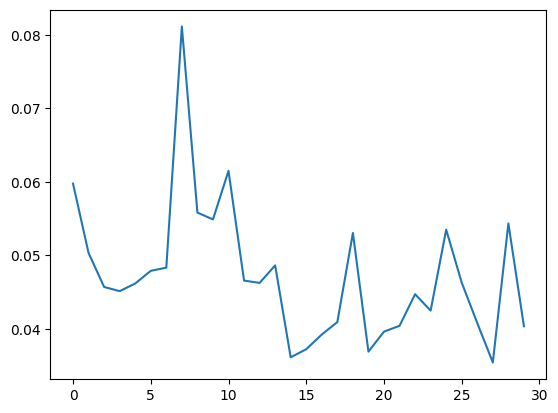

In [54]:
import matplotlib.pyplot as plt
plt.plot(loss_graph)

In [55]:
for x, y in zip(x_test, y_test):
    out = lstm_model.forward(x[0], train=False)[0] 
    print(f"White Prediction: {int(out[0].item() * max_elo)} vs White Real Elo: {int(y[0].item() * max_elo)}")
    loss = loss_func(out, y[0].unsqueeze(0))

    out = lstm_model.forward(x[1], train=False)[0]
    print(f"Black Prediction: {int(out[0].item() * max_elo)} vs Black Real Elo: {int(y[1].item() * max_elo)}")
    loss = loss_func(out, y[1].unsqueeze(0))

White Prediction: 2493 vs White Real Elo: 2334
Black Prediction: 2783 vs Black Real Elo: 2316
White Prediction: 1210 vs White Real Elo: 1788
Black Prediction: 1402 vs Black Real Elo: 1777
White Prediction: 2084 vs White Real Elo: 2161
Black Prediction: 2760 vs Black Real Elo: 2238
White Prediction: 1995 vs White Real Elo: 2207
Black Prediction: 1801 vs Black Real Elo: 2213
White Prediction: 1709 vs White Real Elo: 2202
Black Prediction: 1319 vs Black Real Elo: 2108
White Prediction: 1329 vs White Real Elo: 810
Black Prediction: 1280 vs Black Real Elo: 859
White Prediction: 1680 vs White Real Elo: 1363
Black Prediction: 1596 vs Black Real Elo: 1304
White Prediction: 2006 vs White Real Elo: 1549
Black Prediction: 2048 vs Black Real Elo: 1551
White Prediction: 1230 vs White Real Elo: 1117
Black Prediction: 1236 vs Black Real Elo: 1146
White Prediction: 1282 vs White Real Elo: 1342
Black Prediction: 1330 vs Black Real Elo: 1314
White Prediction: 1051 vs White Real Elo: 804
Black Prediction